# Electric current in metals: toy model

toy model to simulate and demonstrate electric currents in a metal. We assume 2D to keep it simple to visualise.
Notation may be a bit harder to read as all particles are kept in a long array (eg. x is the array of x coordinates for all charge carriers in the simulation) this allows an important speed gain in the simulation (but more optimisation is definitely possible but not the goal here)

things to try out:
-play with number of particles and study current behavior
-increase field Ex and see what happens with current
-does ohms law hold? (also for small nr of particles?, also for very high
field strengths?)
-switch models between 'classic' and 'statistical' to see differences,
-judge which one would be closer to reality especially when studying the instanteneous current

what does it say about measuring really small currents in small devices (low np)? or really high field strengths?

(c) Jo Verbeeck, EMAT, University of Antwerp, Sept 2019

load the required libraries for calculation and plotting

In [57]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import matplotlib.animation as anm

Initialise

In [2]:
rnd.seed(None) #make sure random gen does not repeat itself

model='classic'
#model='statistical'

#create a square 2D conductor
w=5e-6 #width in [m]
h=w #height in [m]

#create a set of charge carriers
q=-1.6e-19 #charge of electrons [C]
m=9.1e-31 #electron rest mass [kg]
npart=50 #number of particles in the box
kB=1.38e-23 #Boltzman constant [m^2kgs^-2K-1]
T=300 #absolute temperature [K]
#vth=1e5 #thermal speed of electrons (assume constant here, in reality it is a stochastic variable [m/s], todo: relate to temp 
vth=np.sqrt(3*kB*T/m) #3D electron gas assumed, to be strict there are only 2 degrees of freedom which would turn the '3' into a '2'
l=100e-9 #free path length [m] (depends on purity of materials and density of defects, remember: no material is ever really perfect)
tau=l/vth #free time [s]

Define constant electric field over the box in x direction

In [3]:
ex=100000 #electric field in x direction [V/m] (note above 1e5 very few materials would survive, but parabolic trajectory becomes hard to notice)
ey=0 #electric field in y direction [V/m]

#create random initial positions of particles
xinit=rnd.random(npart)*w
yinit=rnd.random(npart)*h
thetainit=rnd.random(npart)*2*np.pi #random flight angle in xy plane

Plot the particles in the conductor box

(-5.829608798251672e-08,
 5.106047057959277e-06,
 5.817142363463766e-08,
 5.2225145695764315e-06)

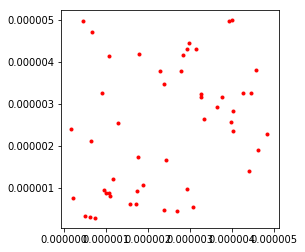

In [4]:
plt.plot(xinit,yinit,'r.')
plt.axis('square')

Run over time (take enough time points to keep accuracy, do convergence test, this depends also on E field)

In [95]:
tpoints=1000
tmax=10*tau
t=np.tile(np.linspace(0,tmax,tpoints),[npart,1]) #each particle has its own timescale that gets reset when a collision occurs
#t=np.transpose(t)
x=xinit
y=yinit
theta=thetainit

if (model=='statistical'):
        vx=vth*np.cos(theta)+tau*q*ex/m #assume the particle has a past, it already gained an average acceleration over a time tau (approximate but better than assuming 0)
        vy=vth*np.sin(theta)+tau*q*ey/m
else :
        #(model=='classic'):
        vx=vth*np.cos(theta)+tau*q*ex/(2*m) #assume the particle has a past, it already gained an average acceleration over a time tau (approximate but better than assuming 0)
        vy=vth*np.sin(theta)+tau*q*ey/(2*m)
        
dt=tmax/tpoints

In [10]:
tau

8.559726695111711e-13

ValueError: operands could not be broadcast together with shapes (1,50) (1000,) 

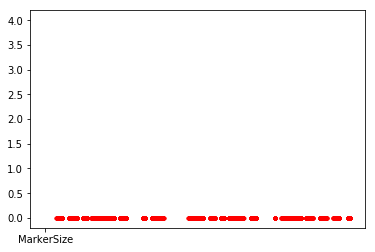

In [96]:
jx=np.zeros(tpoints)
jy=np.zeros(tpoints)
figure = plt.figure()

for tid in range(tpoints):
    #calculate new point some time later   
    x=x+vx*dt
    y=y+vy*dt
    #and acceleration term due to E field
    vx=vx+np.ones(vx.shape)*dt*q*ex/m
    vy=vy+np.ones(vy.shape)*dt*q*ey/m
    
    #calculate current
    jx[tid]=npart*q*np.mean(vx) #instantenous current (note the random fluctuation which should get less for more particles)
    jy[tid]=npart*q*np.mean(vy) #instantenous current (note the random fluctuation which should get less for more particles)
    
    #check if they hit the wall and keep them inside box by modulo
    x=np.mod(x,w) #particle that dissapear through top wall will reappear bottom to keep nr of particles constant
    y=np.mod(y,h) #particle that dissapear through right wall will reappear left to keep nr of particles constant
     
    #reset speed and direction in case a collision with impurity occurs
    if (model=='statistical'):
            #careful with this formula, contains statistical difficulties,
            #as we do a statistical draw in each time point which needs to
            #be compensated (otherwise more time points would lead to
            #faster collision)        
            draw=np.exp(np.divide(-t[:,tid],tau*(t[:,tid]/dt + np.ones(npart)) )) #a vector with indices for those particles that have a collision now (statistical model for exponential chance of colliding)
            collid=np.where(np.random(npart)>draw)
                        
    else:
            #classical model
            collid=np.nonzero(t[:,tid]>(tau*np.ones(npart))) #classical collision all collide when t==tau
    if (collid[0].size>0) :      
            np.mean(t[collid,tid]) #should be close to tau if statistics is correct
            t[collid,:]=t[collid,:]-t[collid,tid]*np.ones(tpoints) #reset time to zero for those particles that had a collision
            theta[collid]=rnd.random(theta(collid).shape)*2*np.pi #new angle for those particles that had a collision
            vx[collid]=np.multiply(vth,np.cos(theta[collid])) #in case of collision take new speed, otherwise keep old speed
            vy[collid]=np.multiply(vth,np.sin(theta[collid]))
       
    #show
    plt.plot(x,y,'r.',x[collid],y[collid],'b.','MarkerSize',4)
plt.show() 
j=np.mean(jx)
sigma=np.mean(jx)/ex #conductivity estimate (with stochastic noise)
mu=sigma/(npart*q) #mobility estimate

In [43]:
collid[0].size>0

False

Compare with analytical results from course notes

In [ ]:
mus=q*tau/m 
sigmas=npart*q**2*tau/m 
muc=q*tau/(2*m) 
sigmac=npart*q**2*tau/(2*m) 

In [ ]:
plt.plot(t[1,:],jx,'b',t[1,:],sigmas*ex*np.ones(jx.shape),'r',t[1,:],sigmac*ex*np.ones(jx.shape),'g')
plt.title('instantenous current')
plt.xlabel('t')
plt.ylabel('J')
plt.legend('Jx','statistical prediction','classical prediction')